In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *
from tqdm import tqdm

## Read TIC catalog

In [2]:
tic = pd.read_csv('../tic.txt',sep='\t')
tic.head()

,tic_id,Tmag
0,269273552,-1.745
1,175934060,-1.679
2,459832522,-1.254
3,245873777,-1.200
4,272314138,-1.043


### Reading in `eleanor-lite` output file

In [3]:
data = pd.read_csv('../eleanor-lite-combined-v2.txt',sep=',',header=None)
with open("colnames.json", "r") as f:
        check = f.read()
        columns = json.loads(check)
        columns = columns["column_names"]
data.columns = columns
data.head()

,path,TIC_ID,signal,snr,time,asym_score,amplitude,width,skewness,skewness_err,...,n,chisq_gauss,chisq_skew,rchisq_gauss,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob
0,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,141426240,-5.80624,-3.47911,1393.44856,-5.0,-5.0,-5.0,-5.0,-5.0,...,309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gapJustBefore
1,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,79570523,-8.74077,-3.15225,1405.78473,-2.0,-2.0,-2.0,-2.0,-2.0,...,901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,end
2,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,120898034,-5.10636,-4.09137,1392.14042,-3.0,-3.0,-3.0,-3.0,-3.0,...,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,noModelFitted
3,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,146246780,-5.67224,-3.91087,1397.20272,-6.0,-6.0,-6.0,-6.0,-6.0,...,489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gapJustAfter
4,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,75375449,-11.39842,-3.65238,1397.22474,-6.0,-6.0,-6.0,-6.0,-6.0,...,490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gapJustAfter


In [4]:
len_data = len(data)
len_data

10039930

### Importing older one for comparison

In [5]:
df2 = pd.read_csv('../combined_dataframe_xrp.txt', header=None)
len_df2 = len(df2)
with open("colnames.json", "r") as f:
        check = f.read()
        columns = json.loads(check)
        columns = columns["column_names"]
df2.columns = columns
df2 = df2[df2.transit_prob == 'maybeTransit']
df2 = df2[(df2.asym_score <= 3)].reset_index(drop=True)
print(f"{(len(df2)/len_df2)*100} candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.")

41.51781033527172 candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.


### Cleaning main dataframe

In [6]:
data = data[data.transit_prob == 'maybeTransit']
data = data[(data.asym_score <= 3)].reset_index(drop=True)
data['Sector'] = data['path'].str.extract(r'/s(\d+)/').astype(int)
data.insert(2, 'Sector', data.pop('Sector'))
print(f"{(len(data)/len_data)*100}% candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.")

45.91982215015443% candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.


## Distribution of main dataframe

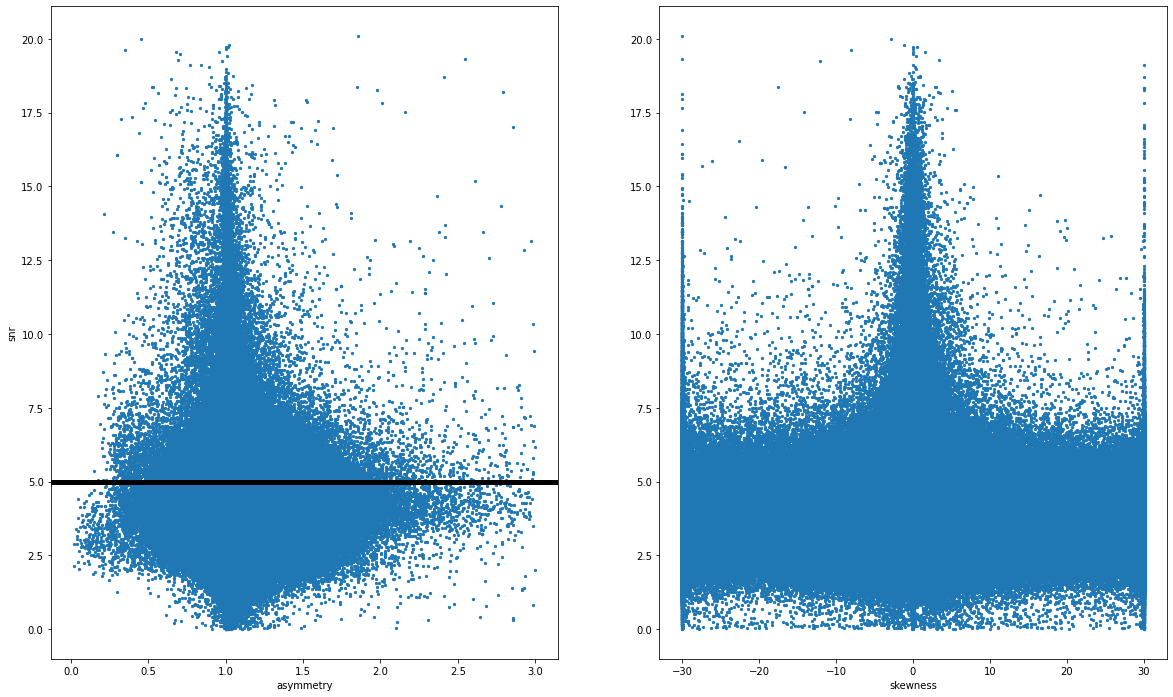

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[0].axhline(y=5,linewidth=5,color='black')
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

### Comparison with XRP dataframe

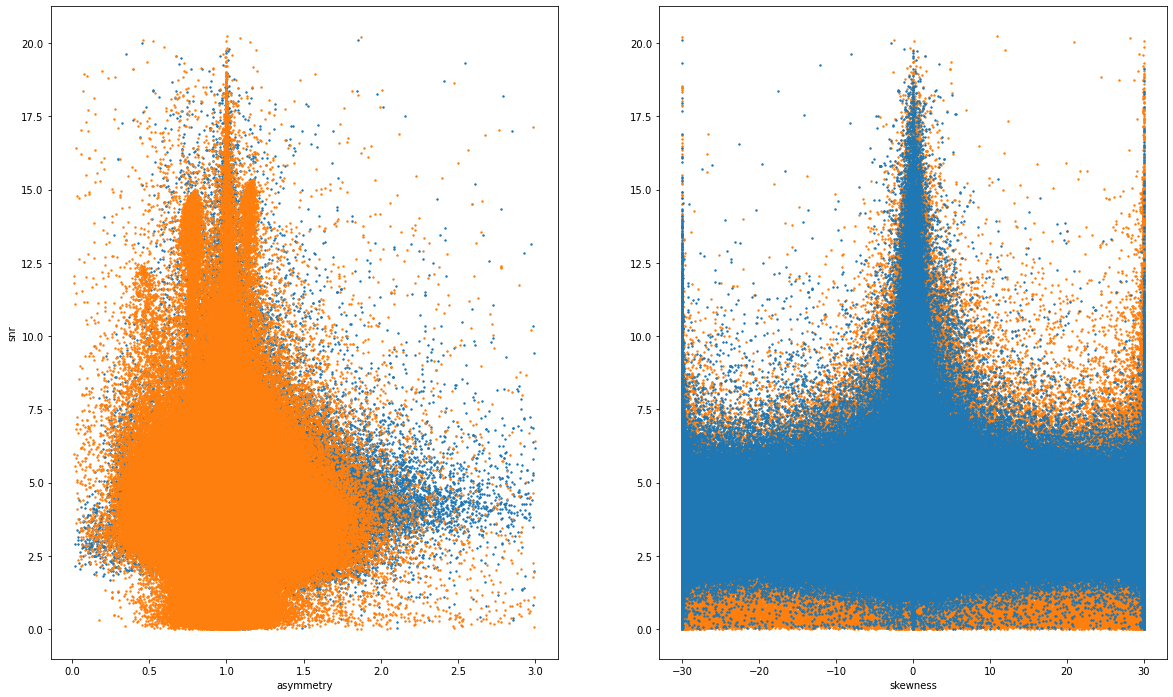

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
ax[0].scatter(data.asym_score,abs(data.snr),s=2,zorder=3)
ax[0].scatter(df2.asym_score,abs(df2.snr),s=2,zorder=3)
ax[0].set_xlabel("asymmetry")
ax[0].set_ylabel("snr")
ax[1].set_xlabel("skewness")
ax[1].scatter(data.skewness,abs(data.snr),s=2,zorder=3)
ax[1].scatter(df2.skewness,abs(df2.snr),s=2,zorder=2)

plt.show()

## SNR Cut 

In [9]:
data_new = data[data.snr <= 0]
data_new = data[abs(data.snr) >= 5].reset_index(drop=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

267844 candidates remain, 2.667787524415011 from main sample.


In [10]:
tqdm.pandas()

data_new['abs_path'] = data_new['path'].progress_apply(lambda x: x.replace('/tmp/eleanor-lite/', '/storage/astro2/phrdhx/eleanor-lite-project-v2/'))

100%|██████████| 267844/267844 [00:00<00:00, 711503.02it/s]


In [11]:
data_new

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,chisq_gauss,chisq_skew,rchisq_gauss,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path
0,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,92994196,3,-9.57415,-5.69956,1401.01616,0.99149,0.00057,0.13937,0.81840,...,82.11910,81.56677,1.86634,1.85379,0.00042,0.00042,0.00035,0.00035,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
1,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,149500178,3,-7.08428,-5.10423,1404.44873,1.10124,0.00065,0.15622,23.51829,...,31.62947,27.69746,0.56481,0.49460,0.00103,0.00098,0.00082,0.00077,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
2,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,149387915,3,-8.03753,-5.19343,1387.94873,1.02207,0.00023,0.07391,-6.67474,...,63.74425,62.35704,1.44873,1.41721,0.00137,0.00136,0.00115,0.00112,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
3,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,123334490,3,-10.12100,-5.66535,1404.47343,0.89587,0.00037,0.15971,-1.37627,...,38.69569,35.34922,0.87945,0.80339,0.00029,0.00031,0.00023,0.00023,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
4,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,92994201,3,-12.29501,-5.78550,1401.03700,0.81208,0.00365,0.25670,1.81871,...,3998.76511,3456.08753,105.23066,90.94967,0.00158,0.00175,0.00124,0.00133,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267839,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,469086661,9,-8.16620,-5.07836,1548.92986,1.19309,0.00090,0.04809,-3.26000,...,15.78396,12.86092,0.78920,0.64305,0.00098,0.00090,0.00073,0.00069,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
267840,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,463517167,9,-13.57604,-5.24651,1547.51341,0.99903,0.00320,0.49286,1.47474,...,372.56143,370.64690,4.04958,4.02877,0.00098,0.00098,0.00076,0.00076,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
267841,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,464362924,9,-8.74332,-5.17373,1546.22182,1.02157,0.00442,0.48476,2.13436,...,105.51223,103.43243,1.31890,1.29291,0.00189,0.00187,0.00145,0.00138,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
267842,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,730840442,9,-17.86754,-5.27994,1565.34394,1.01643,0.00444,0.18809,1.21220,...,186.94937,183.79604,1.69954,1.67087,0.00091,0.00090,0.00068,0.00068,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...


In [12]:
# for i in data_new[(data_new.skewness >= 30) & (abs(data_new.snr) > 7) & (abs(data_new.duration) > 0.4)].path.head(10): #4 x 4 grid for illustration purposes
#     #print(len(data_new[(data_new.asym_score >=0.9) & (data_new.asym_score <= 1) & (abs(data_new.depth) >= 0.1)]))
#     lc, lc_info = import_lightcurve(i)
#     lc = lc['TIME','CORR_FLUX','QUALITY','FLUX_ERR','FLUX_BKG']
#     _, _ = processing(lc,lc_info=lc_info,method='median',make_plots=True)

---
### Catalog Cross-Referencing

In [13]:
ebs = pd.read_csv('../catalogs/eb_cat.txt')
tois = pd.read_csv('../catalogs/exofop_tess_tois.csv')

tois = tois.reset_index()
tois = tois['level_0'][1:]
tois = tois.values.astype(int)

In [14]:
ebs_found = data_new[data_new['TIC_ID'].isin(ebs['ID'])]
tois_found =  data_new[data_new['TIC_ID'].isin(tois)]

In [15]:
# Step 1: Create a boolean mask
data_new['is_eb'] = data_new['TIC_ID'].isin(ebs['ID'])
data_new['is_toi'] = data_new['TIC_ID'].isin(tois)

In [16]:
log_peak_power = np.log10(data_new['peak_lspower'])
log_depth = np.log10(abs(data_new['depth']))

In [17]:
frac_dur = data_new.duration[(data_new.is_eb == False) & (data_new.is_toi == False)]
frac_depth = data_new.depth[(data_new.is_eb == False) & (data_new.is_toi == False)]

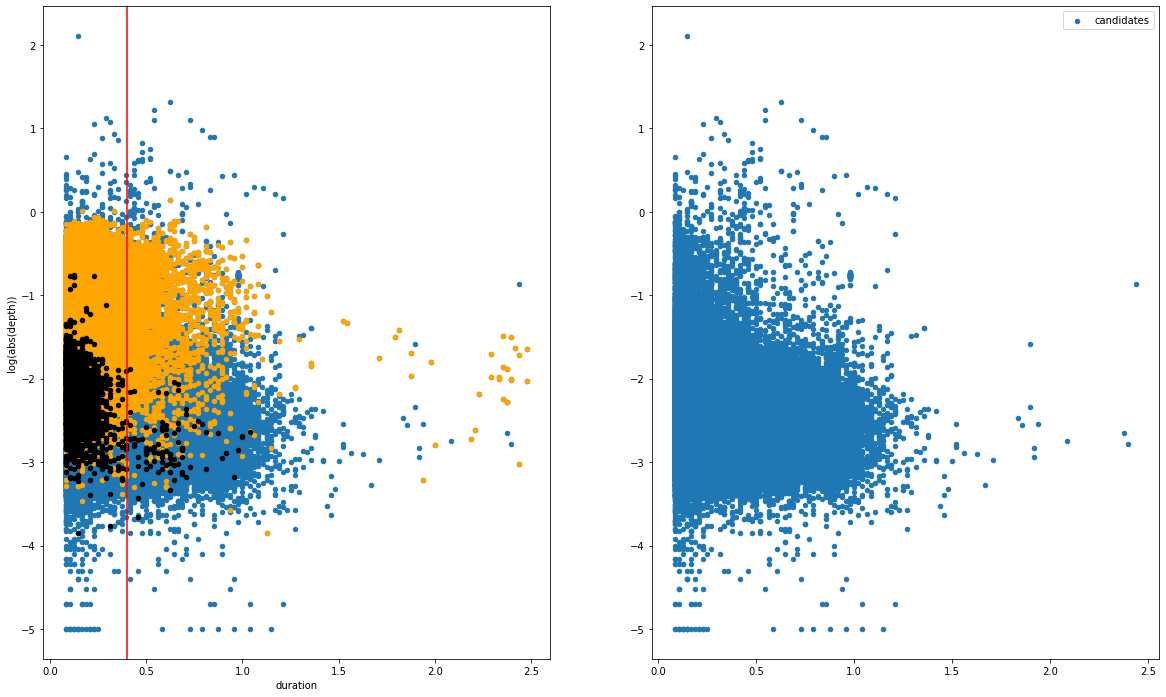

In [18]:
fig, ax = plt.subplots(ncols=2,figsize=(20,12))

ax[0].scatter(data_new.duration,log_depth,s=20,label='candidates',zorder=1)
ax[0].scatter(ebs_found.duration,np.log10(abs(ebs_found['depth'])),c='orange',s=20,label='ebs')
ax[0].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='black',s=20,label='tois')

ax[1].scatter(frac_dur,np.log10(abs(frac_depth)),s=20,label='candidates',zorder=1)
#ax[1].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='black',s=20,label='tois')



ax[0].set_xlabel('duration')
ax[0].set_ylabel('log(abs(depth))')
ax[0].axvline(0.4,c='red')

plt.legend()

### Duration Cut (0.4 days)

In [19]:
data_new.drop(data_new[data_new['duration'] <= 0.4].index,inplace=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

54434 candidates remain, 0.5421750948462788 from main sample.


### Depth Cut (1%)

In [20]:
data_new.drop(data_new[data_new['depth'] > 0].index,inplace=True)
data_new['abs_depth'] = abs(data_new.depth)
data_new.drop(data_new[(data_new['abs_depth'] >= 0.01)].index,inplace=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

50201 candidates remain, 0.5000134463088887 from main sample.


In [21]:
data_new

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path,is_eb,is_toi,abs_depth
14,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,101040310,3,-8.84133,-5.03004,1404.47203,0.98469,0.00027,0.30622,-29.99257,...,0.69477,0.00020,0.00020,0.00015,0.00015,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00069
57,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,140686847,3,-11.61651,-5.09832,1391.49037,1.16161,0.00179,0.35167,-13.93521,...,1.38528,0.00129,0.00120,0.00098,0.00090,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00396
70,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142305477,3,-12.64399,-5.19826,1404.47261,1.20060,0.00059,0.46274,-30.00000,...,1.41786,0.00027,0.00025,0.00021,0.00017,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00100
104,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,149217216,3,-7.54512,-5.09955,1404.15728,1.04955,0.00038,0.26985,-30.00000,...,0.50710,0.00063,0.00061,0.00050,0.00048,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00111
173,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142218811,3,-12.39479,-5.20685,1404.47244,1.01238,0.00051,0.43465,-30.00000,...,2.11082,0.00025,0.00025,0.00019,0.00019,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267749,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,462654959,9,-10.16900,-5.72424,1563.49287,1.07560,0.00057,0.43588,30.00000,...,0.86729,0.00048,0.00046,0.00037,0.00036,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00104
267774,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,448415627,9,-9.17579,-5.32041,1566.51558,1.01762,0.00034,0.27573,3.01673,...,0.75142,0.00038,0.00037,0.00030,0.00030,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00081
267806,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,685267970,9,-10.21697,-5.30488,1566.46794,1.06724,0.00124,0.39270,6.35810,...,1.12534,0.00083,0.00080,0.00066,0.00063,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00234
267807,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,463915142,9,-7.57797,-5.02789,1546.97153,1.05064,0.00204,1.23339,9.87863,...,0.94331,0.00082,0.00080,0.00064,0.00061,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00127


---
## For sub 1% transits

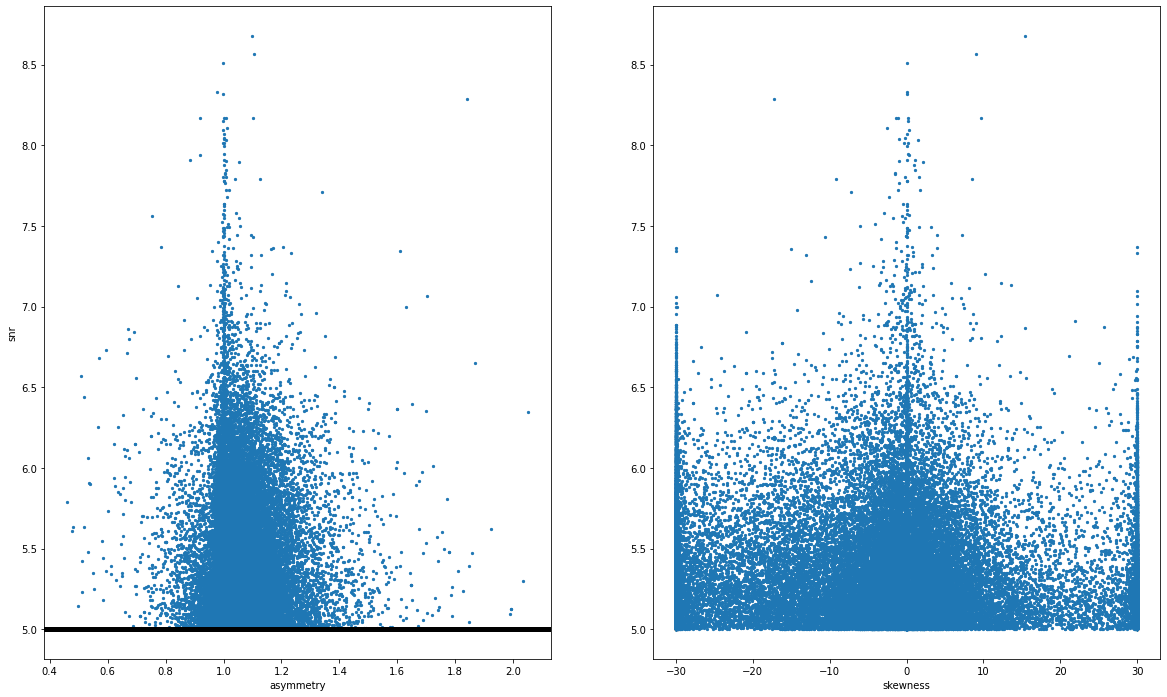

remaining candidates: 50201


In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
ax[0].scatter(data_new.asym_score,abs(data_new.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[0].axhline(y=5,linewidth=5,color='black')
ax[1].scatter(data_new.skewness,abs(data_new.snr),s=5)
plt.show()
print(f"remaining candidates: {len(data_new)}")

In [12]:
# for i in data_new[(data_new.asym_score >= 1) & (abs(data_new.snr) > 5)].path.head(5): #4 x 4 grid for illustration purposes
#     #print(len(data_new[(data_new.asym_score >=0.9) & (data_new.asym_score <= 1) & (abs(data_new.depth) >= 0.1)]))
#     lc, lc_info = import_lightcurve(i)
#     lc = lc['TIME','CORR_FLUX','QUALITY','FLUX_ERR','FLUX_BKG']
#     _, _ = processing(lc,lc_info=lc_info,method='median',make_plots=True)

In [25]:
data_new.to_csv('../eleanor-lite-v2_candidates.csv',index=False)

In [26]:
data_new

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path,is_eb,is_toi,abs_depth
14,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,101040310,3,-8.84133,-5.03004,1404.47203,0.98469,0.00027,0.30622,-29.99257,...,0.69477,0.00020,0.00020,0.00015,0.00015,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00069
57,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,140686847,3,-11.61651,-5.09832,1391.49037,1.16161,0.00179,0.35167,-13.93521,...,1.38528,0.00129,0.00120,0.00098,0.00090,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00396
70,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142305477,3,-12.64399,-5.19826,1404.47261,1.20060,0.00059,0.46274,-30.00000,...,1.41786,0.00027,0.00025,0.00021,0.00017,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00100
104,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,149217216,3,-7.54512,-5.09955,1404.15728,1.04955,0.00038,0.26985,-30.00000,...,0.50710,0.00063,0.00061,0.00050,0.00048,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00111
173,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142218811,3,-12.39479,-5.20685,1404.47244,1.01238,0.00051,0.43465,-30.00000,...,2.11082,0.00025,0.00025,0.00019,0.00019,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267749,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,462654959,9,-10.16900,-5.72424,1563.49287,1.07560,0.00057,0.43588,30.00000,...,0.86729,0.00048,0.00046,0.00037,0.00036,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00104
267774,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,448415627,9,-9.17579,-5.32041,1566.51558,1.01762,0.00034,0.27573,3.01673,...,0.75142,0.00038,0.00037,0.00030,0.00030,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00081
267806,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,685267970,9,-10.21697,-5.30488,1566.46794,1.06724,0.00124,0.39270,6.35810,...,1.12534,0.00083,0.00080,0.00066,0.00063,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00234
267807,/tmp/eleanor-lite/s0009/hlsp_gsfc-eleanor-lite...,463915142,9,-7.57797,-5.02789,1546.97153,1.05064,0.00204,1.23339,9.87863,...,0.94331,0.00082,0.00080,0.00064,0.00061,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00127
